<a href="https://colab.research.google.com/github/MetronWard/Computer-Vision-Course/blob/main/Chapter_2_Convolution_Layers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [24]:
import torch
import torch.nn as nn
import torch.optim.lr_scheduler as lr_scheduler
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim

import torchvision
from torchvision import models
import torchvision.transforms as T
from torchvision.datasets import ImageFolder

from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, ConfusionMatrixDisplay

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from tqdm import tqdm

# Download Dataset

In [10]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("asadullahgalib/guava-disease-dataset")

print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/guava-disease-dataset


In [11]:
ds_folder = path+"/GuavaDiseaseDataset/GuavaDiseaseDataset/"

In [12]:
img_size = (224, 224)
img_channels = 3
batch_size = 64
lr = 1e-3

# Datasets and DataLoaders

In [13]:
train_dataset = ImageFolder(root=ds_folder + "train/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.RandomHorizontalFlip(0.5),
                                T.RandomVerticalFlip(0.5),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [14]:
test_dataset = ImageFolder(root=ds_folder + "test/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [15]:
val_dataset = ImageFolder(root=ds_folder + "val/",
                            transform=T.Compose([
                                T.Resize(img_size),
                                T.ToTensor(),
                                T.Normalize([0.5]*3, [0.5]*3)]),
                            )

In [16]:
train_dl = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
val_dl = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

# Training Functins

In [17]:
def train_step(model, data_loader, criterion, optimizer, scheduler):

  n_samples = len(data_loader.dataset)

  progress_bar = tqdm(data_loader, desc="Training")
  total_loss = 0.0
  total_correct = 0.0

  model.train()

  for image, label in progress_bar:
    images, labels = image.cuda(), label.cuda()

    optimizer.zero_grad()

    predictions = model(images)
    predicted_classes = torch.argmax(predictions, dim=1)
    correct_classes = torch.sum(predicted_classes == labels)
    loss = criterion(predictions, labels)

    total_correct += correct_classes.item()
    total_loss += loss.item()

    loss.backward()
    optimizer.step()
  scheduler.step(loss.item())

  return total_loss/n_samples, 100 * (total_correct/n_samples)

In [18]:
def evaluate(model, data_loader, criterion):

  model.eval()

  n_samples = len(data_loader.dataset)

  progress_bar = tqdm(data_loader, desc="Evaluating")
  total_loss = 0.0
  total_correct = 0.0

  with torch.no_grad():

    for image, label in progress_bar:
      images, labels = image.cuda(), label.cuda()

      predictions = model(images)
      predicted_classes = torch.argmax(predictions, dim=1)
      correct_classes = torch.sum(predicted_classes == labels)
      loss = criterion(predictions, labels)

      total_correct += correct_classes.item()
      total_loss += loss.item()

  return total_loss/n_samples, 100 * (total_correct/n_samples)

In [19]:
def fit(model, train_dataloader, val_dataloader, criterion, optimizer, scheduler, epochs, experiment_name):

  df = pd.DataFrame(np.empty([epochs, 5]),
                    index=np.arange(epochs),
                    columns=["Train_Loss", "Train_Acc", "Val_Loss", "Val_Acc", "lr"])

  highest_acc = 0.00

  for epoch in range(epochs):
    print(f"Epoch {epoch+1}")

    df.iloc[epoch, 0], df.iloc[epoch, 1] = train_step(model=model, data_loader=train_dataloader,
                                            criterion=criterion, optimizer=optimizer,
                                            scheduler=scheduler)

    df.iloc[epoch, 2], df.iloc[epoch, 3] = evaluate(model=model, data_loader=val_dataloader,
                                            criterion=criterion)

    df.iloc[epoch, 4] = optimizer.param_groups[0]["lr"]

    print(f"Training Loss = {df.iloc[epoch, 0]:.7f}, Training Accuracy = {df.iloc[epoch, 1]:.3f}\nTesting Loss = {df.iloc[epoch, 2]:.7f}, Testing Accuracy = {df.iloc[epoch, 3]:.3f}")


    if df.iloc[epoch, 3] > highest_acc:
      torch.save(model.state_dict(), f"{experiment_name}.pth")
      highest_acc = df.iloc[epoch, 3]
      print(f"New best accuracy: {highest_acc:.3f} at epoch {epoch+1}")

    print("*"*50)
    print("")

  return df

# FC Neural Network

In [20]:
class FC_Model(nn.Module):
  def __init__(self, skeleton:list, num_classes):
    super().__init__()
    layer_list = []
    for i in range(len(skeleton) -1):
      layer_list.append(nn.Linear(skeleton[i], skeleton[i+1]))
      layer_list.append(nn.BatchNorm1d(skeleton[i+1]))
      layer_list.append(nn.Dropout1d(0.5))
      layer_list.append(nn.ReLU())
    layer_list.append(nn.Linear(skeleton[-1], num_classes))
    self.model = nn.Sequential(*layer_list)

  def forward(self, images):
    inputs = images.view(images.shape[0], -1)
    output = self.model(inputs)
    return output

In [21]:
model = FC_Model(skeleton=[img_size[0]*img_size[1]*3, 500, 300, 200, 100, 50, 20], num_classes=3).cuda()

In [22]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=lr)
scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [23]:
fc_df = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=50, experiment_name="fully_connected")

Epoch 1


Evaluating: 100%|██████████| 12/12 [00:12<00:00,  1.01s/it]


Training Loss = 0.0175684, Training Accuracy = 0.394
Testing Loss = 0.0172934, Testing Accuracy = 0.408
New best accuracy: 0.408 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Training Loss = 0.0173521, Training Accuracy = 0.391
Testing Loss = 0.0172660, Testing Accuracy = 0.409
New best accuracy: 0.409 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Training Loss = 0.0172791, Training Accuracy = 0.403
Testing Loss = 0.0172593, Testing Accuracy = 0.405
**************************************************

Epoch 4


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Training Loss = 0.0172285, Training Accuracy = 0.410
Testing Loss = 0.0172088, Testing Accuracy = 0.408
**************************************************

Epoch 5


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Training Loss = 0.0171759, Training Accuracy = 0.405
Testing Loss = 0.0171383, Testing Accuracy = 0.409
**************************************************

Epoch 6


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Training Loss = 0.0171230, Training Accuracy = 0.411
Testing Loss = 0.0171988, Testing Accuracy = 0.408
**************************************************

Epoch 7


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.42it/s]


Training Loss = 0.0172361, Training Accuracy = 0.406
Testing Loss = 0.0172117, Testing Accuracy = 0.408
**************************************************

Epoch 8


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Training Loss = 0.0171031, Training Accuracy = 0.408
Testing Loss = 0.0171875, Testing Accuracy = 0.411
New best accuracy: 0.411 at epoch 8
**************************************************

Epoch 9


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Training Loss = 0.0171374, Training Accuracy = 0.406
Testing Loss = 0.0171821, Testing Accuracy = 0.409
**************************************************

Epoch 10


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.59it/s]


Training Loss = 0.0170456, Training Accuracy = 0.411
Testing Loss = 0.0171794, Testing Accuracy = 0.412
New best accuracy: 0.412 at epoch 10
**************************************************

Epoch 11


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0171894, Training Accuracy = 0.405
Testing Loss = 0.0171924, Testing Accuracy = 0.411
**************************************************

Epoch 12


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0171119, Training Accuracy = 0.411
Testing Loss = 0.0171410, Testing Accuracy = 0.417
New best accuracy: 0.417 at epoch 12
**************************************************

Epoch 13


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Training Loss = 0.0171004, Training Accuracy = 0.412
Testing Loss = 0.0171935, Testing Accuracy = 0.408
**************************************************

Epoch 14


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Training Loss = 0.0171063, Training Accuracy = 0.409
Testing Loss = 0.0171802, Testing Accuracy = 0.412
**************************************************

Epoch 15


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.49it/s]


Training Loss = 0.0170983, Training Accuracy = 0.410
Testing Loss = 0.0171587, Testing Accuracy = 0.416
**************************************************

Epoch 16


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0170826, Training Accuracy = 0.408
Testing Loss = 0.0171707, Testing Accuracy = 0.411
**************************************************

Epoch 17


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Training Loss = 0.0170948, Training Accuracy = 0.409
Testing Loss = 0.0171832, Testing Accuracy = 0.408
**************************************************

Epoch 18


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Training Loss = 0.0170806, Training Accuracy = 0.411
Testing Loss = 0.0171564, Testing Accuracy = 0.413
**************************************************

Epoch 19


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0170859, Training Accuracy = 0.409
Testing Loss = 0.0171753, Testing Accuracy = 0.411
**************************************************

Epoch 20


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Training Loss = 0.0171393, Training Accuracy = 0.402
Testing Loss = 0.0171796, Testing Accuracy = 0.409
**************************************************

Epoch 21


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0170773, Training Accuracy = 0.409
Testing Loss = 0.0171726, Testing Accuracy = 0.413
**************************************************

Epoch 22


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0170895, Training Accuracy = 0.413
Testing Loss = 0.0171561, Testing Accuracy = 0.419
New best accuracy: 0.419 at epoch 22
**************************************************

Epoch 23


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Training Loss = 0.0171259, Training Accuracy = 0.406
Testing Loss = 0.0171525, Testing Accuracy = 0.415
**************************************************

Epoch 24


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Training Loss = 0.0171525, Training Accuracy = 0.405
Testing Loss = 0.0171749, Testing Accuracy = 0.409
**************************************************

Epoch 25


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.58it/s]


Training Loss = 0.0170708, Training Accuracy = 0.407
Testing Loss = 0.0171577, Testing Accuracy = 0.411
**************************************************

Epoch 26


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Training Loss = 0.0170731, Training Accuracy = 0.411
Testing Loss = 0.0171801, Testing Accuracy = 0.408
**************************************************

Epoch 27


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.57it/s]


Training Loss = 0.0171080, Training Accuracy = 0.410
Testing Loss = 0.0171728, Testing Accuracy = 0.411
**************************************************

Epoch 28


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Training Loss = 0.0170897, Training Accuracy = 0.405
Testing Loss = 0.0171744, Testing Accuracy = 0.411
**************************************************

Epoch 29


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.52it/s]


Training Loss = 0.0171287, Training Accuracy = 0.404
Testing Loss = 0.0171810, Testing Accuracy = 0.411
**************************************************

Epoch 30


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.54it/s]


Training Loss = 0.0171346, Training Accuracy = 0.413
Testing Loss = 0.0171521, Testing Accuracy = 0.411
**************************************************

Epoch 31


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.55it/s]


Training Loss = 0.0170485, Training Accuracy = 0.415
Testing Loss = 0.0171775, Testing Accuracy = 0.409
**************************************************

Epoch 32


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.56it/s]


Training Loss = 0.0170825, Training Accuracy = 0.413
Testing Loss = 0.0171697, Testing Accuracy = 0.413
**************************************************

Epoch 33


Evaluating: 100%|██████████| 12/12 [00:07<00:00,  1.50it/s]


Training Loss = 0.0170628, Training Accuracy = 0.410
Testing Loss = 0.0171661, Testing Accuracy = 0.409
**************************************************

Epoch 34


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Training Loss = 0.0170732, Training Accuracy = 0.409
Testing Loss = 0.0171799, Testing Accuracy = 0.411
**************************************************

Epoch 35


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0170457, Training Accuracy = 0.412
Testing Loss = 0.0171750, Testing Accuracy = 0.411
**************************************************

Epoch 36


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Training Loss = 0.0170778, Training Accuracy = 0.410
Testing Loss = 0.0171918, Testing Accuracy = 0.408
**************************************************

Epoch 37


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0170831, Training Accuracy = 0.412
Testing Loss = 0.0171820, Testing Accuracy = 0.411
**************************************************

Epoch 38


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0171232, Training Accuracy = 0.408
Testing Loss = 0.0171668, Testing Accuracy = 0.412
**************************************************

Epoch 39


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Training Loss = 0.0171290, Training Accuracy = 0.404
Testing Loss = 0.0171687, Testing Accuracy = 0.413
**************************************************

Epoch 40


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.48it/s]


Training Loss = 0.0170978, Training Accuracy = 0.410
Testing Loss = 0.0171690, Testing Accuracy = 0.411
**************************************************

Epoch 41


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0171526, Training Accuracy = 0.406
Testing Loss = 0.0171557, Testing Accuracy = 0.411
**************************************************

Epoch 42


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.47it/s]


Training Loss = 0.0170855, Training Accuracy = 0.411
Testing Loss = 0.0171776, Testing Accuracy = 0.412
**************************************************

Epoch 43


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]


Training Loss = 0.0171533, Training Accuracy = 0.411
Testing Loss = 0.0171578, Testing Accuracy = 0.413
**************************************************

Epoch 44


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Training Loss = 0.0171069, Training Accuracy = 0.404
Testing Loss = 0.0171554, Testing Accuracy = 0.417
**************************************************

Epoch 45


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.43it/s]


Training Loss = 0.0171039, Training Accuracy = 0.413
Testing Loss = 0.0171863, Testing Accuracy = 0.409
**************************************************

Epoch 46


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Training Loss = 0.0171418, Training Accuracy = 0.404
Testing Loss = 0.0171607, Testing Accuracy = 0.411
**************************************************

Epoch 47


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.44it/s]


Training Loss = 0.0170581, Training Accuracy = 0.410
Testing Loss = 0.0171685, Testing Accuracy = 0.417
**************************************************

Epoch 48


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Training Loss = 0.0170869, Training Accuracy = 0.414
Testing Loss = 0.0171859, Testing Accuracy = 0.409
**************************************************

Epoch 49


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.45it/s]


Training Loss = 0.0170791, Training Accuracy = 0.407
Testing Loss = 0.0171712, Testing Accuracy = 0.408
**************************************************

Epoch 50


Evaluating: 100%|██████████| 12/12 [00:08<00:00,  1.46it/s]

Training Loss = 0.0170548, Training Accuracy = 0.413
Testing Loss = 0.0171729, Testing Accuracy = 0.408
**************************************************



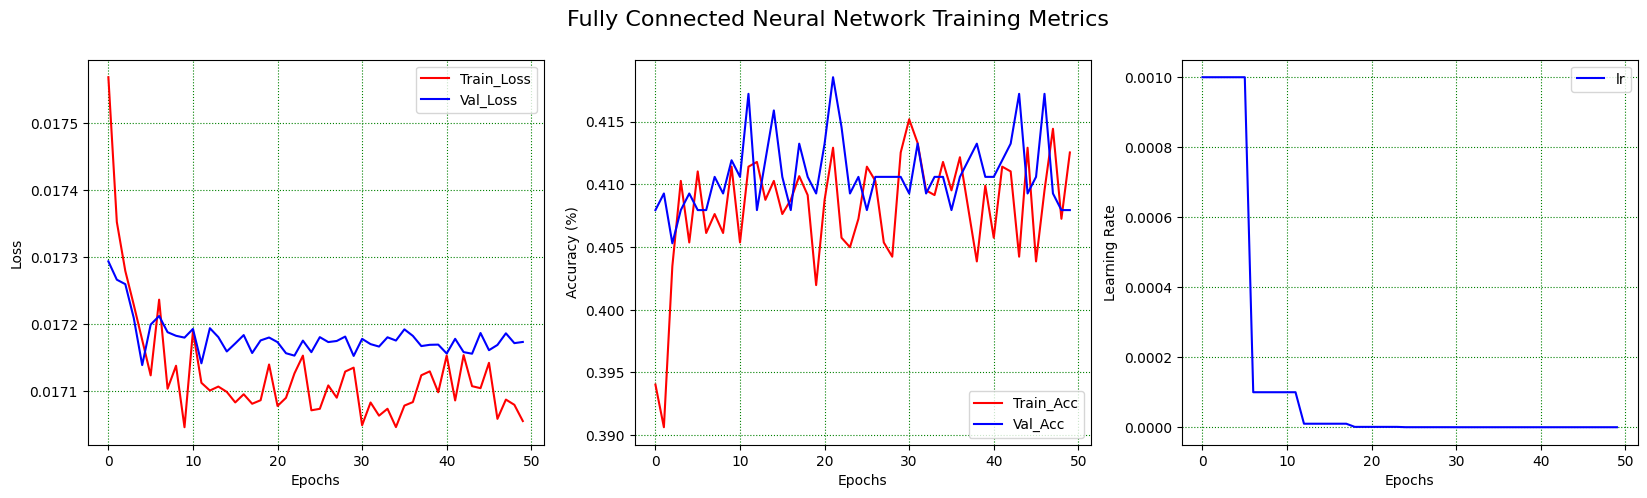

In [43]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

fc_df.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
fc_df.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
fc_df.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Fully Connected Neural Network Training Metrics', fontsize=16,)
plt.show()

# Custom CNN Layer - RESNet 9

In [49]:
def basic(in_channels, out_channels):
  return nn.Sequential(
      nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1, bias=False),
      nn.BatchNorm2d(out_channels),
      nn.Dropout2d(0.3),
      nn.ReLU(inplace=True),
  )

In [50]:
class RS_block(nn.Module):
  def __init__(self, in_channels, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.net = nn.Sequential(
        basic(in_channels, in_channels),
        basic(in_channels, in_channels),
        basic(in_channels, in_channels)
    )

  def forward(self, x):
    return x + self.net(x)

In [54]:
class ResNet9(nn.Module):

  def __init__(self, in_channels=img_channels, num_classes=3, *args, **kwargs) -> None:
    super().__init__(*args, **kwargs)
    self.net = nn.Sequential(
        basic(in_channels, 8),
        basic(8, 32), nn.MaxPool2d(2),
        RS_block(32),
        basic(32, 64),
        basic(64, 128), nn.MaxPool2d(2),
        RS_block(128),
        basic(128, 256), nn.MaxPool2d(2),
        basic(256, 512), nn.MaxPool2d(2),
        RS_block(512),
        nn.AdaptiveAvgPool2d((1, 1)),
        nn.Flatten(),
        nn.Linear(512, num_classes)
    )

  def forward(self, x):
    output = self.net(x)
    return output

In [55]:
model = ResNet9().cuda()

criterion=nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [56]:
my_cnn = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=50, experiment_name="my_cnn")

Epoch 1


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Training Loss = 0.9666101, Training Accuracy = 0.547
Testing Loss = 1.7284434, Testing Accuracy = 0.248
New best accuracy: 0.248 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.16it/s]


Training Loss = 0.7732622, Training Accuracy = 0.653
Testing Loss = 0.9813289, Testing Accuracy = 0.522
New best accuracy: 0.522 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Training Loss = 0.7370431, Training Accuracy = 0.688
Testing Loss = 0.7037714, Testing Accuracy = 0.654
New best accuracy: 0.654 at epoch 3
**************************************************

Epoch 4


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.6889914, Training Accuracy = 0.700
Testing Loss = 0.9735879, Testing Accuracy = 0.551
**************************************************

Epoch 5


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


Training Loss = 0.6357308, Training Accuracy = 0.731
Testing Loss = 0.7753813, Testing Accuracy = 0.601
**************************************************

Epoch 6


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Training Loss = 0.6300530, Training Accuracy = 0.737
Testing Loss = 0.8040248, Testing Accuracy = 0.615
**************************************************

Epoch 7


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Training Loss = 0.6003752, Training Accuracy = 0.751
Testing Loss = 0.6764790, Testing Accuracy = 0.690
New best accuracy: 0.690 at epoch 7
**************************************************

Epoch 8


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Training Loss = 0.5733217, Training Accuracy = 0.761
Testing Loss = 0.6303848, Testing Accuracy = 0.682
**************************************************

Epoch 9


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.5688271, Training Accuracy = 0.773
Testing Loss = 0.6586038, Testing Accuracy = 0.686
**************************************************

Epoch 10


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Training Loss = 0.5200654, Training Accuracy = 0.801
Testing Loss = 0.6423079, Testing Accuracy = 0.706
New best accuracy: 0.706 at epoch 10
**************************************************

Epoch 11


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.5169693, Training Accuracy = 0.794
Testing Loss = 0.6245668, Testing Accuracy = 0.679
**************************************************

Epoch 12


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Training Loss = 0.4802189, Training Accuracy = 0.805
Testing Loss = 0.6135069, Testing Accuracy = 0.668
**************************************************

Epoch 13


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4414336, Training Accuracy = 0.830
Testing Loss = 0.6565606, Testing Accuracy = 0.670
**************************************************

Epoch 14


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4542002, Training Accuracy = 0.813
Testing Loss = 0.6679786, Testing Accuracy = 0.677
**************************************************

Epoch 15


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.4677661, Training Accuracy = 0.803
Testing Loss = 0.6324350, Testing Accuracy = 0.683
**************************************************

Epoch 16


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.4655701, Training Accuracy = 0.823
Testing Loss = 0.6043329, Testing Accuracy = 0.701
**************************************************

Epoch 17


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.14it/s]


Training Loss = 0.4433940, Training Accuracy = 0.828
Testing Loss = 0.6601620, Testing Accuracy = 0.670
**************************************************

Epoch 18


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Training Loss = 0.4424477, Training Accuracy = 0.817
Testing Loss = 0.7404934, Testing Accuracy = 0.675
**************************************************

Epoch 19


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Training Loss = 0.4273115, Training Accuracy = 0.829
Testing Loss = 0.7261815, Testing Accuracy = 0.682
**************************************************

Epoch 20


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4404778, Training Accuracy = 0.824
Testing Loss = 0.6824611, Testing Accuracy = 0.691
**************************************************

Epoch 21


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Training Loss = 0.4174529, Training Accuracy = 0.839
Testing Loss = 0.6713715, Testing Accuracy = 0.694
**************************************************

Epoch 22


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.4095349, Training Accuracy = 0.841
Testing Loss = 0.7204740, Testing Accuracy = 0.683
**************************************************

Epoch 23


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.4440302, Training Accuracy = 0.824
Testing Loss = 0.6495681, Testing Accuracy = 0.698
**************************************************

Epoch 24


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Training Loss = 0.4292811, Training Accuracy = 0.825
Testing Loss = 0.6376607, Testing Accuracy = 0.706
**************************************************

Epoch 25


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4090313, Training Accuracy = 0.839
Testing Loss = 0.6175340, Testing Accuracy = 0.713
New best accuracy: 0.713 at epoch 25
**************************************************

Epoch 26


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4280228, Training Accuracy = 0.828
Testing Loss = 0.7265084, Testing Accuracy = 0.686
**************************************************

Epoch 27


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Training Loss = 0.4209341, Training Accuracy = 0.833
Testing Loss = 0.6664166, Testing Accuracy = 0.702
**************************************************

Epoch 28


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Training Loss = 0.4117969, Training Accuracy = 0.837
Testing Loss = 0.6789416, Testing Accuracy = 0.690
**************************************************

Epoch 29


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.26it/s]


Training Loss = 0.4128016, Training Accuracy = 0.833
Testing Loss = 0.6673862, Testing Accuracy = 0.705
**************************************************

Epoch 30


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.20it/s]


Training Loss = 0.4255332, Training Accuracy = 0.838
Testing Loss = 0.6643100, Testing Accuracy = 0.705
**************************************************

Epoch 31


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Training Loss = 0.4296451, Training Accuracy = 0.833
Testing Loss = 0.6434487, Testing Accuracy = 0.713
**************************************************

Epoch 32


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.18it/s]


Training Loss = 0.4277482, Training Accuracy = 0.836
Testing Loss = 0.6787081, Testing Accuracy = 0.699
**************************************************

Epoch 33


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.11it/s]


Training Loss = 0.4160886, Training Accuracy = 0.840
Testing Loss = 0.7041238, Testing Accuracy = 0.686
**************************************************

Epoch 34


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.20it/s]


Training Loss = 0.4194483, Training Accuracy = 0.830
Testing Loss = 0.6611622, Testing Accuracy = 0.705
**************************************************

Epoch 35


Evaluating: 100%|██████████| 12/12 [00:10<00:00,  1.19it/s]


Training Loss = 0.4133182, Training Accuracy = 0.831
Testing Loss = 0.6923897, Testing Accuracy = 0.697
**************************************************

Epoch 36


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4300392, Training Accuracy = 0.833
Testing Loss = 0.6601978, Testing Accuracy = 0.694
**************************************************

Epoch 37


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4135209, Training Accuracy = 0.827
Testing Loss = 0.7169039, Testing Accuracy = 0.686
**************************************************

Epoch 38


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4213181, Training Accuracy = 0.832
Testing Loss = 0.7131159, Testing Accuracy = 0.689
**************************************************

Epoch 39


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Training Loss = 0.4188057, Training Accuracy = 0.834
Testing Loss = 0.6905176, Testing Accuracy = 0.689
**************************************************

Epoch 40


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.4192830, Training Accuracy = 0.839
Testing Loss = 0.6829439, Testing Accuracy = 0.698
**************************************************

Epoch 41


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.4165969, Training Accuracy = 0.845
Testing Loss = 0.6332668, Testing Accuracy = 0.713
**************************************************

Epoch 42


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4121651, Training Accuracy = 0.835
Testing Loss = 0.6334405, Testing Accuracy = 0.711
**************************************************

Epoch 43


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.4170663, Training Accuracy = 0.824
Testing Loss = 0.6582040, Testing Accuracy = 0.701
**************************************************

Epoch 44


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.29it/s]


Training Loss = 0.4267802, Training Accuracy = 0.832
Testing Loss = 0.6883158, Testing Accuracy = 0.699
**************************************************

Epoch 45


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.23it/s]


Training Loss = 0.4117726, Training Accuracy = 0.842
Testing Loss = 0.6508348, Testing Accuracy = 0.709
**************************************************

Epoch 46


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.22it/s]


Training Loss = 0.4149330, Training Accuracy = 0.838
Testing Loss = 0.6864404, Testing Accuracy = 0.697
**************************************************

Epoch 47


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]


Training Loss = 0.4194768, Training Accuracy = 0.832
Testing Loss = 0.6468954, Testing Accuracy = 0.703
**************************************************

Epoch 48


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.25it/s]


Training Loss = 0.4036644, Training Accuracy = 0.850
Testing Loss = 0.6900148, Testing Accuracy = 0.686
**************************************************

Epoch 49


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.27it/s]


Training Loss = 0.4070920, Training Accuracy = 0.847
Testing Loss = 0.6616068, Testing Accuracy = 0.705
**************************************************

Epoch 50


Evaluating: 100%|██████████| 12/12 [00:09<00:00,  1.21it/s]

Training Loss = 0.4367137, Training Accuracy = 0.825
Testing Loss = 0.6512356, Testing Accuracy = 0.705
**************************************************



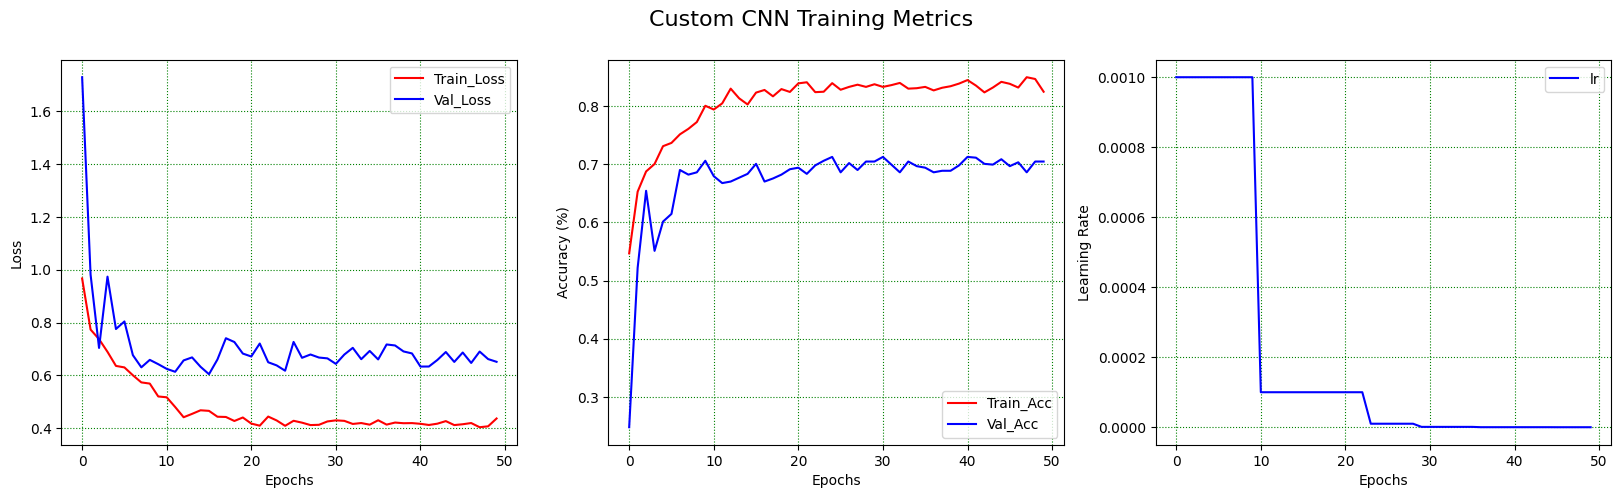

In [58]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

my_cnn.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
my_cnn.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
my_cnn.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Custom CNN  Training Metrics', fontsize=16,)
plt.show()

# Transfer Learning

In [59]:
model = models.resnet101(pretrained=True)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /root/.cache/torch/hub/checkpoints/resnet101-63fe2227.pth
100%|██████████| 171M/171M [00:00<00:00, 192MB/s]


In [60]:
model.eval()

for params in model.parameters():
  params.requires_grad = False

In [61]:
num_ftrs = model.fc.in_features

model.fc = nn.Linear(num_ftrs, 3)

In [62]:
model = model.cuda()

criterion=nn.CrossEntropyLoss(reduction="sum")
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

scheduler = lr_scheduler.ReduceLROnPlateau(optimizer=optimizer, mode="min", patience=5, factor=0.1)

In [63]:
transfer_df = fit(model=model, train_dataloader=train_dl, val_dataloader=val_dl,
            criterion=criterion, optimizer=optimizer, scheduler=scheduler,
            epochs=10, experiment_name="tranfer")

Epoch 1


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Training Loss = 0.5219952, Training Accuracy = 0.819
Testing Loss = 0.2297439, Testing Accuracy = 0.967
New best accuracy: 0.967 at epoch 1
**************************************************

Epoch 2


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Training Loss = 0.1878766, Training Accuracy = 0.961
Testing Loss = 0.1458926, Testing Accuracy = 0.977
New best accuracy: 0.977 at epoch 2
**************************************************

Epoch 3


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Training Loss = 0.1278084, Training Accuracy = 0.974
Testing Loss = 0.0955774, Testing Accuracy = 0.984
New best accuracy: 0.984 at epoch 3
**************************************************

Epoch 4


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Training Loss = 0.0983822, Training Accuracy = 0.978
Testing Loss = 0.0779297, Testing Accuracy = 0.985
New best accuracy: 0.985 at epoch 4
**************************************************

Epoch 5


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.05it/s]


Training Loss = 0.0827348, Training Accuracy = 0.983
Testing Loss = 0.0723428, Testing Accuracy = 0.984
**************************************************

Epoch 6


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Training Loss = 0.0743639, Training Accuracy = 0.986
Testing Loss = 0.0551357, Testing Accuracy = 0.993
New best accuracy: 0.993 at epoch 6
**************************************************

Epoch 7


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.02it/s]


Training Loss = 0.0663467, Training Accuracy = 0.985
Testing Loss = 0.0498855, Testing Accuracy = 0.991
**************************************************

Epoch 8


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.03it/s]


Training Loss = 0.0607426, Training Accuracy = 0.986
Testing Loss = 0.0479364, Testing Accuracy = 0.992
**************************************************

Epoch 9


Evaluating: 100%|██████████| 12/12 [00:11<00:00,  1.04it/s]


Training Loss = 0.0594972, Training Accuracy = 0.985
Testing Loss = 0.0455808, Testing Accuracy = 0.993
**************************************************

Epoch 10


Evaluating: 100%|██████████| 12/12 [00:12<00:00,  1.02s/it]


Training Loss = 0.0551012, Training Accuracy = 0.988
Testing Loss = 0.0352641, Testing Accuracy = 0.999
New best accuracy: 0.999 at epoch 10
**************************************************



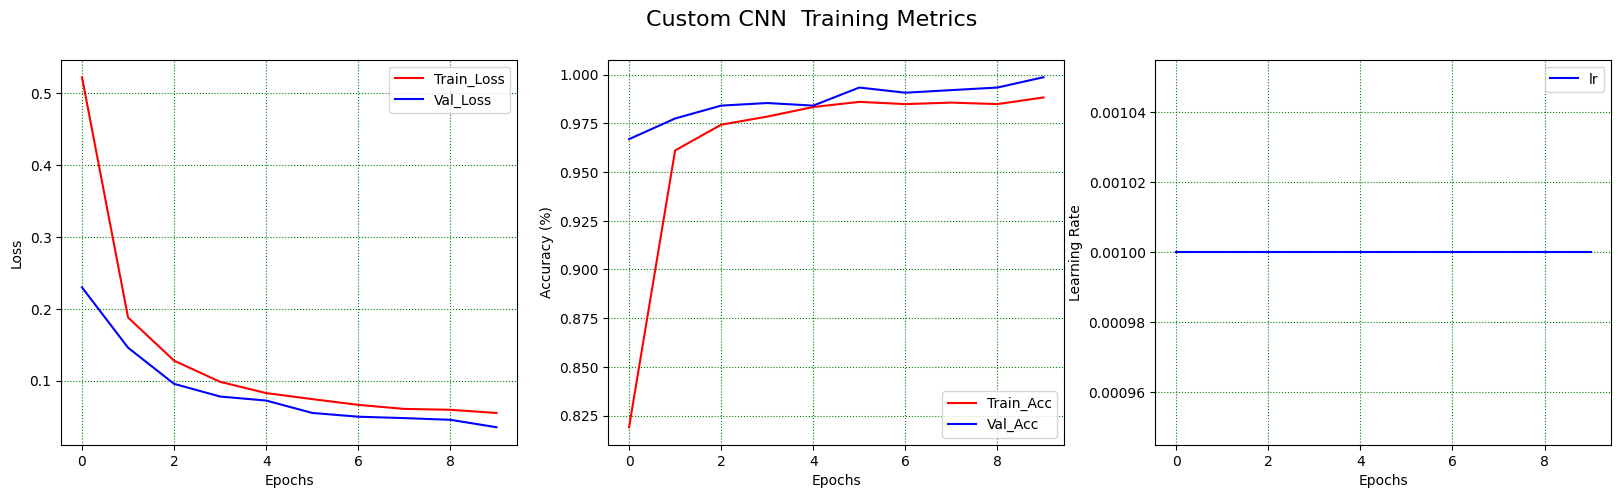

In [64]:
fig, ax = plt.subplots(1, 3, figsize=(20, 5), sharex=True)

transfer_df.plot(ax=ax[0], y=[0, 2], style=["r", "b"])
transfer_df.plot(ax=ax[1], y=[1, 3], style=["r", "b"])
transfer_df.plot(ax=ax[2], y=[4], style=["b"])

for i in range(3):
  ax[i].set_xlabel("Epochs")
  ax[i].grid(which="major", axis="both", color="g", linestyle=":")

ax[0].set_ylabel("Loss")
ax[1].set_ylabel("Accuracy (%)")
ax[2].set_ylabel("Learning Rate")

fig.suptitle('Custom CNN  Training Metrics', fontsize=16,)
plt.show()